In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from plottools import *
from scipy.integrate import quad

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


Sample a (real?) Gaussian in the upper complex plane and see what we recover. Try to impose realistic properties on this Gaussian-- should be nevanlinna as well.

## Initialize parameters and plot original function

In [2]:
zbounds = np.array([[-3, 3], [0, 6]])        # [xbounds, ybounds]
def gaussian(z0, sigma):
    """Returns function handle for a Gaussian centered at (x0, y0) with std sigma"""
    def f(z):
        return (1j) * np.exp(- np.abs(z - z0) ** 2 / (2 * (sigma ** 2))) / (2 * np.pi * sigma)
    return f

In [3]:
dz = 0.1
x = np.arange(zbounds[0, 0], zbounds[0, 1], dz)
y = np.arange(zbounds[1, 0], zbounds[1, 1], dz)
zdomain = np.array([[x[i] + (1j) * y[j] for j in range(len(x))] for i in range(len(y))], dtype = np.complex64)
# f_test = gaussian(0.0 + 3.0 * (1j), 1.0)
z0 = 0.0 + 3.0 * (1j)
f_test = gaussian(z0, 1.0)    # see if making it imaginary fixes precision issues

In [4]:
# choose points to sample. The algorithm is having some issues when the points have equal values.
# sample_bounds = np.array([[-1, 1], [2, 4]])
sample_bounds = np.array([[-2, 2], [1, 5]])
# dsample = 0.2
# dsample = 0.5
dsample = 0.1
# dsample = 0.05
sx = np.arange(sample_bounds[0, 0], sample_bounds[0, 1], dsample)
sy = np.arange(sample_bounds[1, 0], sample_bounds[1, 1], dsample)
# sample_domain = np.array([[sx[i] + (1j) * sy[j] for i in range(len(sx))] for j in range(len(sy))], dtype = np.complex64)
r = 1.0
# r = 0.25
sample_domain = []
for j in range(len(sy)):
    for i in range(len(sx)):
        if ((sx[i] - np.real(z0)) ** 2 + (sy[j] - np.imag(z0)) ** 2 < r ** 2):
            sample_domain.append(sx[i] + (1j) * sy[j])
sample_domain = np.array(sample_domain, dtype = np.complex64)
samples = np.array(list(map(f_test, sample_domain)))


In [5]:
# fake input to use to see what we get out
freqs = sample_domain.flatten()
C = samples.flatten()
# Only use unique function values to see what happens
# _, unique_idxs = np.unique(C, return_index = True)
# freqs = freqs[unique_idxs]
# C = C[unique_idxs]

<IPython.core.display.Javascript object>


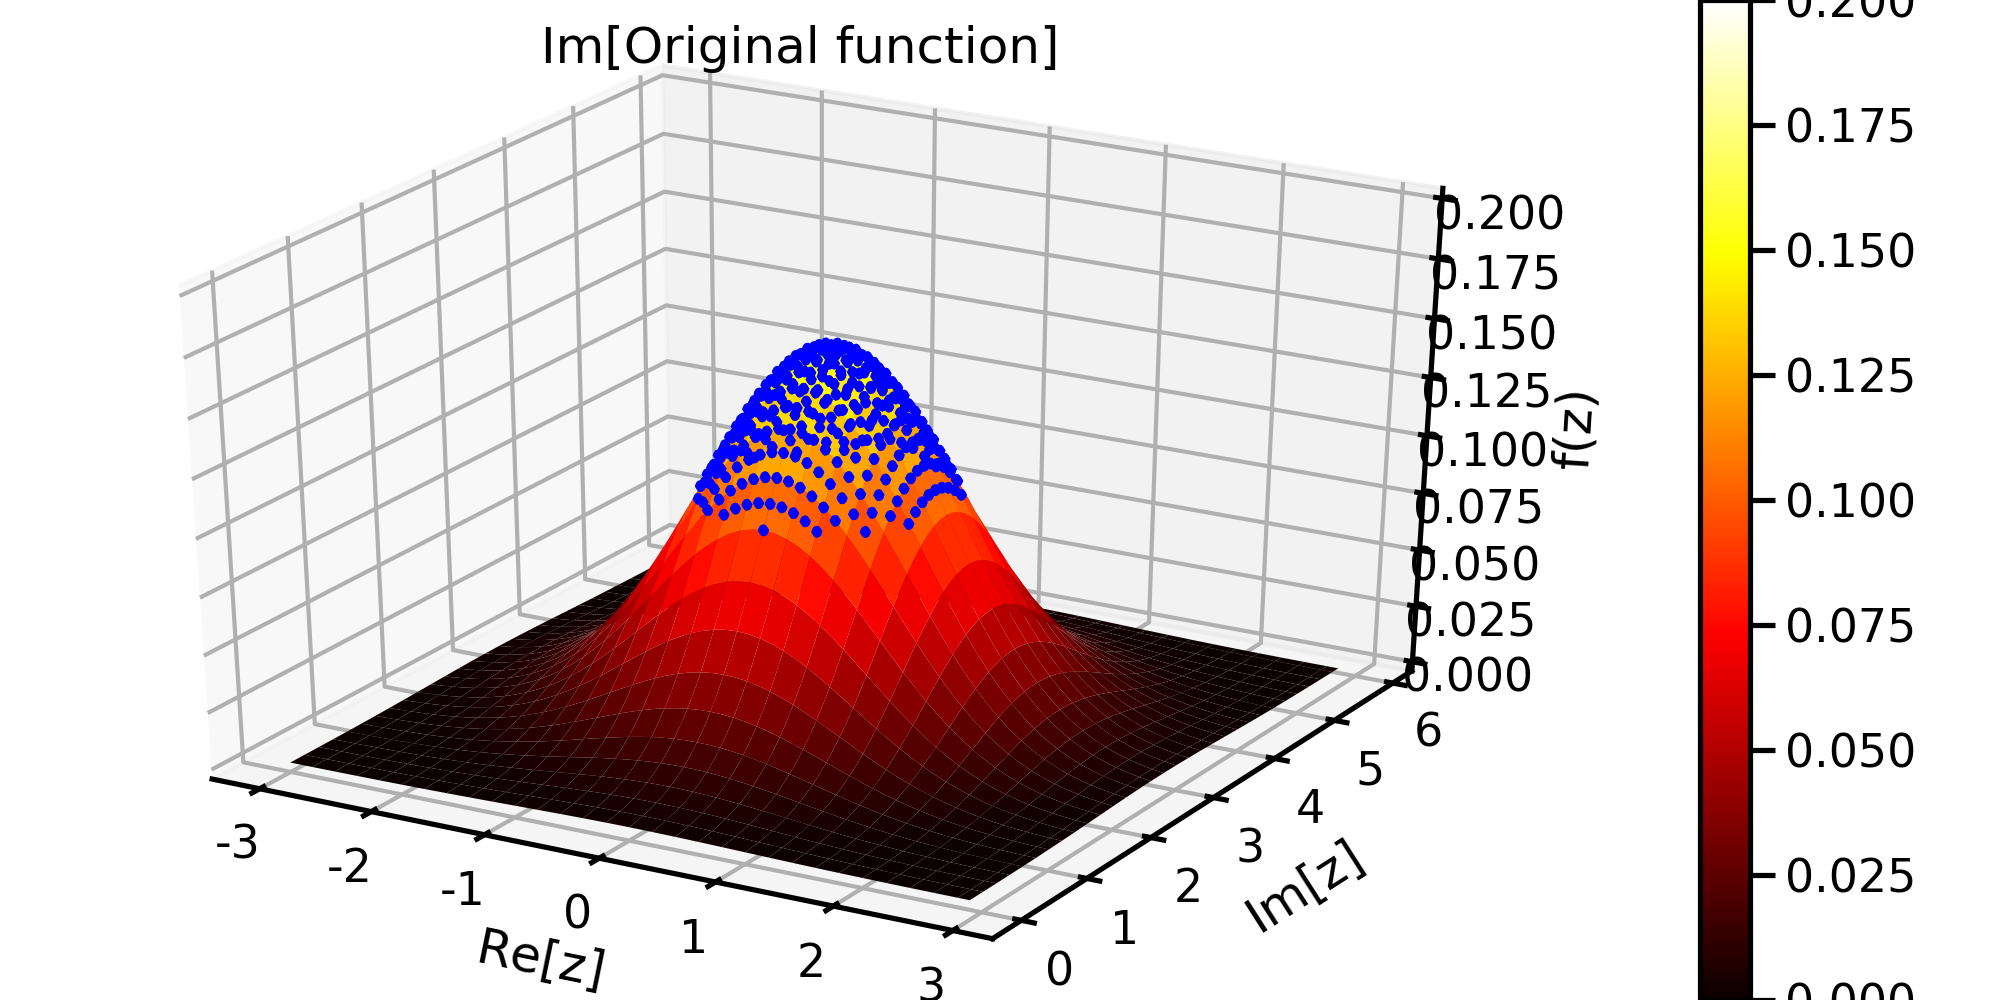

In [6]:
epsilon = 1e-3 + 0j
C_plot = np.array([tmp + epsilon for tmp in C])
f_plot = np.array(list(map(f_test, zdomain)))
with sns.plotting_context('talk'):
    fig = plt.figure(figsize = (10, 5))
    ax3 = Axes3D(fig)
    # _, graph3 = plot_complex3D(ax3, x, y, np.real(f_plot), title = 'Re[Original function]', alpha = 1.0, vmin = 0.0, vmax = 0.2)
    _, graph3 = plot_complex3D(ax3, x, y, np.imag(f_plot), title = 'Im[Original function]', alpha = 1.0, vmin = 0.0, vmax = 0.2, zbounds = (0., 0.2))
    # add_points(ax3, np.real(freqs), np.imag(freqs), np.real(C_plot), col = 'b')
    add_points(ax3, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph3)

<IPython.core.display.Javascript object>


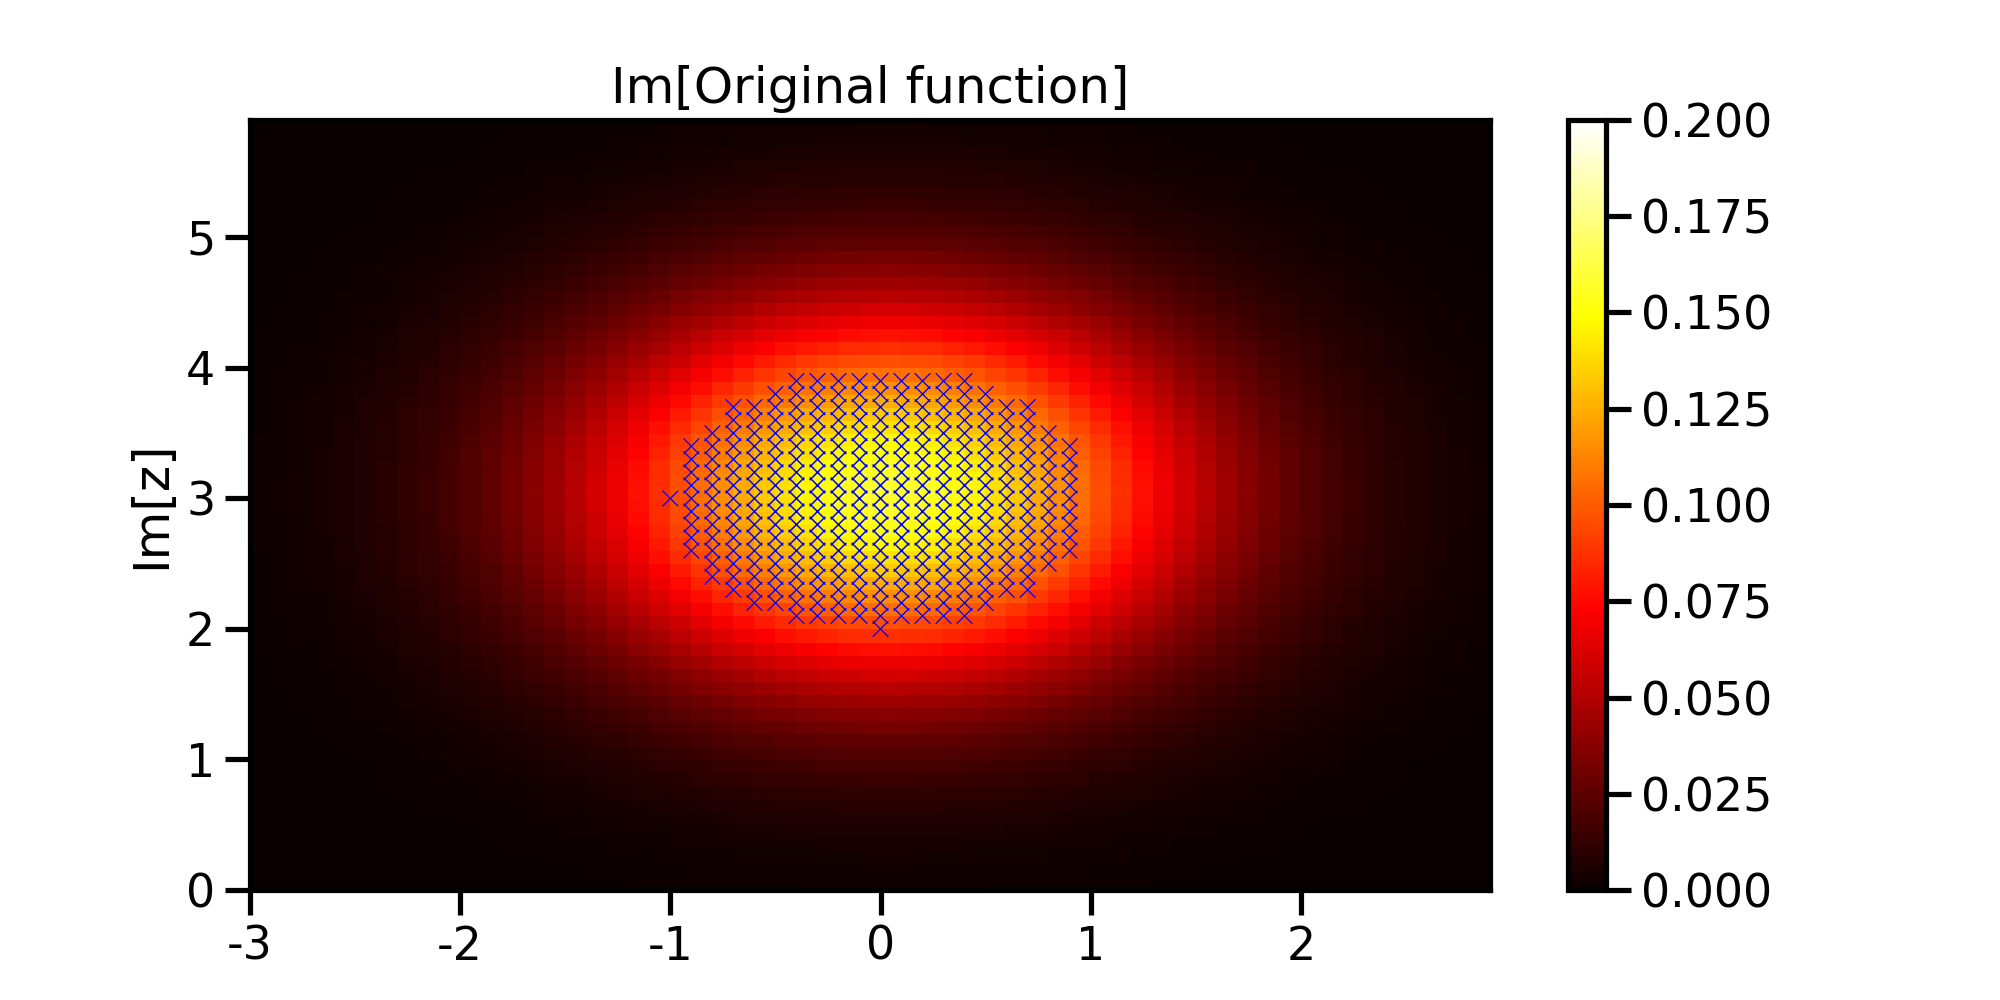

In [7]:
with sns.plotting_context('talk'):
    fig, ax2 = plt.subplots(1, figsize = (10, 5))
    # _, graph = plot_complex2D(ax2, x, y, np.real(f_plot), title = 'Re[Original function]', col = 'hot', vmin = 0.0, vmax = 0.2)
    # add_points(ax2, np.real(freqs), np.imag(freqs), np.real(C_plot), col = 'b')
    _, graph = plot_complex2D(ax2, x, y, np.imag(f_plot), title = 'Im[Original function]', col = 'hot', vmin = 0.0, vmax = 0.2)
    add_points(ax2, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph)

## Sample from function and perform analytic continuation

In [8]:
theta_mp1 = lambda z : 0
# theta_mp1 = hardy(1)
Y = np.array([gmp.mpc(float(np.real(x)), float(np.imag(x))) for x in freqs])
C_gmp = np.array([gmp.mpc(float(np.real(x)), float(np.imag(x))) for x in C])
zinterp = zdomain.flatten()
# x_interp, y_interp = np.real(zinterp), np.imag(zinterp)

In [9]:
lambdas = np.array([h(z) for z in C_gmp])
phis = construct_phis(Y, lambdas)
cont = analytic_continuation(Y, phis, zinterp, theta_mp1)
# cont = analytic_continuation(Y, phis, freqs, theta_mp1)
cont_float = np.array([np.complex(x) for x in cont])

In [10]:
cont_plot = np.reshape(cont_float, zdomain.shape)
with sns.plotting_context('talk'):
    fig = plt.figure(figsize = (10, 5))
    ax4 = Axes3D(fig)
    # _, graph4 = plot_complex3D(ax4, x, y, np.real(cont_plot), title = 'Re[interpolant]', alpha = 1.0, vmin = 0.0, vmax = 0.2)
    # add_points(ax4, np.real(freqs), np.imag(freqs), C_plot, col = 'b')
    _, graph4 = plot_complex3D(ax4, x, y, np.imag(cont_plot), title = 'Im[interpolant]', alpha = 1.0, vmin = 0.0, vmax = 0.2, zbounds = (0., 0.2))
    add_points(ax4, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph4)

<IPython.core.display.Javascript object>

In [11]:
np.where(np.imag(cont_plot) < 0.)[0]

array([ 0,  0,  0, ..., 59, 59, 59])

<IPython.core.display.Javascript object>


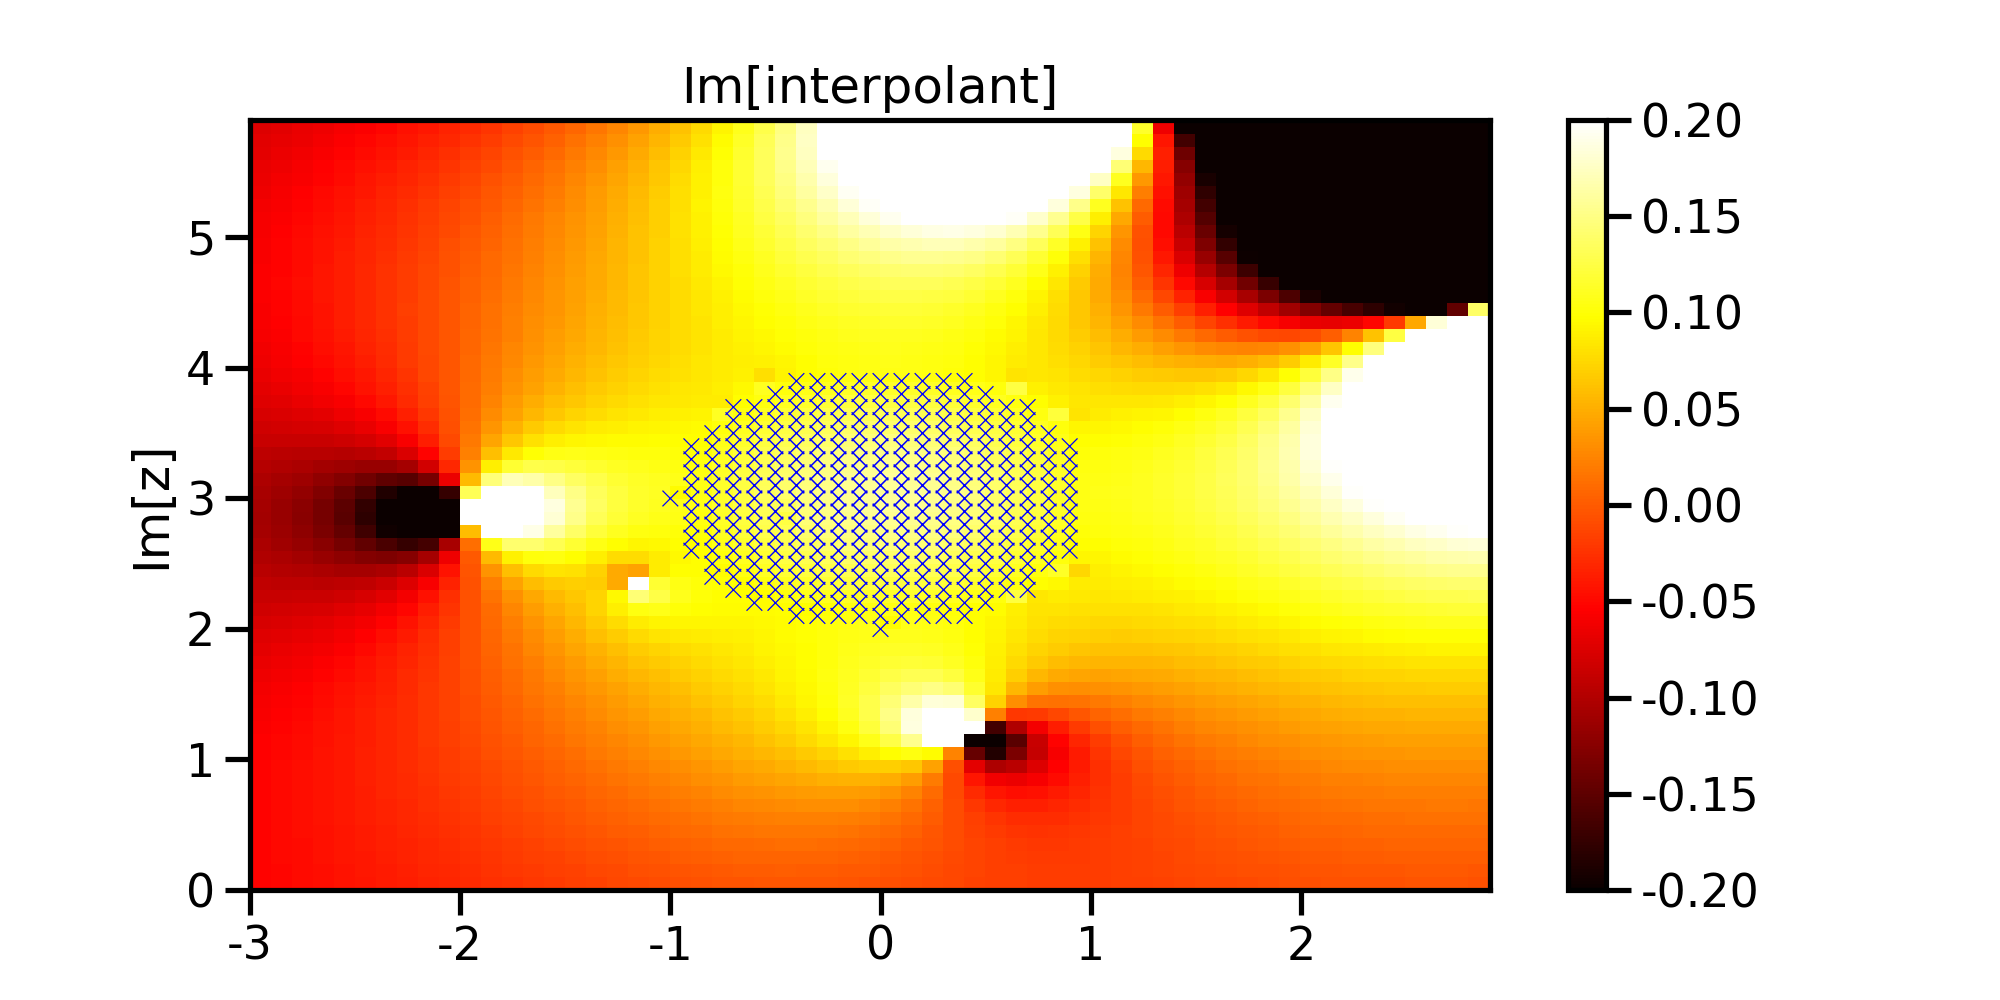

In [12]:
with sns.plotting_context('talk'):
    fig, ax5 = plt.subplots(1, figsize = (10, 5))
    # _, graph5 = plot_complex2D(ax5, x, y, np.real(cont_plot), title = 'Re[interpolant]', vmin = 0.0, vmax = 0.2)
    # add_points(ax5, np.real(freqs), np.imag(freqs), np.real(C_plot), col = 'b')
    _, graph5 = plot_complex2D(ax5, x, y, np.imag(cont_plot), title = 'Im[interpolant]', vmin = -0.2, vmax = 0.2)
    add_points(ax5, np.real(freqs), np.imag(freqs), np.imag(C_plot), col = 'b')
    plt.colorbar(graph5)

In [13]:
# Sanity check: this should vanish if it's a valid continuation
Ntest = 10
for seed in range(50):
    np.random.seed(seed)
    pts = np.random.choice(len(phis), size = Ntest, replace = False)
    print(pts)
    phi_sub = construct_phis(Y[pts], lambdas[pts])
    cont_sample_pts = analytic_continuation(Y[pts], phi_sub, freqs[pts], theta_mp1)
#     cont_sample_pts = analytic_continuation(Y[pts], phi_sub, Y[pts], theta_mp1)
    print(np.array([np.complex(x) for x in cont_sample_pts]) - C[pts])

[ 63 231 167 159 189 145 268  65  26  66]
[-1.16153039e-39+0.j  2.73448709e-38+0.j  3.08567800e-39+0.j
  2.22765127e-39+0.j  1.42242007e-38+0.j -5.51559699e-39+0.j
 -2.78044956e-39+0.j -2.23739229e-39+0.j -2.04448179e-39+0.j
 -1.17829820e-39+0.j]
[238 257 214  70 139 283 293 164 223 165]
[ 6.06679235e-38+0.j -8.54661725e-38+0.j  5.14333759e-38+0.j
 -2.25851856e-39+0.j  4.09201241e-38+0.j  9.33977423e-39+0.j
 -1.67226223e-39+0.j -3.37899220e-39+0.j  4.33183150e-41+0.j
 -1.13198366e-38+0.j]
[172 274   7  84 214 297 244 133 142 114]
[-3.33576218e-39+0.j  1.78897759e-38+0.j  1.48552352e-39+0.j
  1.58008153e-39+0.j -1.20677361e-38+0.j  5.64047035e-40+0.j
 -8.83117962e-40+0.j  1.95823168e-39+0.j  1.71138465e-39+0.j
 -1.01225358e-39+0.j]
[218 297 199 294 272 303 306 140  73  46]
[ 2.53083675e-40+0.j -3.45265642e-39+0.j -6.38267205e-39+0.j
 -1.81439397e-39+0.j  1.81755500e-39+0.j -1.07573256e-39+0.j
 -2.08366557e-39+0.j -5.67647001e-40+0.j  8.20538108e-40+0.j
 -4.19997886e-40+0.j]
[ 14  18 223

In [14]:
# Sanity check: this should vanish if it's a valid continuation
# pts = [61, 49]    # fixed this problem
pts = [17, 33]
print(pts)
print(C[pts])
phi_sub = construct_phis(Y[pts], lambdas[pts])
print(phi_sub)
cont_sample_pts = analytic_continuation(Y[pts], phi_sub, Y[pts], theta_mp1)
print(np.array([np.complex(x) for x in cont_sample_pts]) - C[pts])

[17, 33]
[0.+0.1149938j 0.+0.1149938j]
[mpc('-0.7937319404189217394193523520657366523946-0.0j',(128,128))
 mpc('-1.991538946933350039966398702280457662461e-07-4.868210337508734521960305049052912640389e-07j',(128,128))]
[0.00000000e+00+0.j 7.41726319e-49+0.j]


In [15]:
# # a2
# xi10 = (Y[pts][1] - Y[pts][0]) / (Y[pts][1] - conj(Y[pts][0]))
# print(xi10)
# # b2
# print(lambdas[pts][0])
# # c2
# print(conj(lambdas[pts][0]) * xi10)

In [16]:
# # phi1 and phi2
# phi1 = lambdas[pts][0]
# phi2 = 1. / xi10 * (lambdas[pts][0] - lambdas[pts][1]) / (conj(lambdas[pts][0]) * lambdas[pts][1] - 1)
# print(phi1, phi2)

In [17]:
# output for phi2
# print(phi_sub)

In [18]:
# cont_sample_pts

In [19]:
# C[pts]

In [20]:
# # explicitly construct theta1
# # num = xi10 * phi2 + phi1
# # denom = conj(phi1) * xi10 * phi2 + 1
# num = xi10 * phi_sub[1] + phi_sub[0]
# denom = conj(phi_sub[0]) * xi10 * phi_sub[1] + 1
# theta1Y2 = num / denom
# NGY2 = hinv(theta1Y2)
# # here is the problem: when C_i is real (when lambda_i has unit norm), num and denom become very very small and 
# # suffer from precision issues
# print(num)
# print(denom)
# print(theta1Y2)
# print(NGY2)

## Play with continued fractions and see what's up